In [1]:
# imports

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns
import numpy as np

from alpha import Alpha
import time

In [2]:
start = time.time()

In [3]:
plt.style.use('seaborn-v0_8')
colourmap = pl.cm.cool(np.linspace(0, 1, 4))

In [4]:
# dataloader arguments
batch_size = 200
data_path = '/tmp/data/kmnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Define a transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))])

kmnist_train = datasets.KMNIST(
    data_path, train=True, download=True, transform=transform)
kmnist_test = datasets.KMNIST(data_path, train=False,
                            download=True, transform=transform)

0.4%

100.0%


Extracting /tmp/data/kmnist\KMNIST\raw\train-images-idx3-ubyte.gz to /tmp/data/kmnist\KMNIST\raw


100.0%


Extracting /tmp/data/kmnist\KMNIST\raw\train-labels-idx1-ubyte.gz to /tmp/data/kmnist\KMNIST\raw




100.0%
100.0%


Extracting /tmp/data/kmnist\KMNIST\raw\t10k-images-idx3-ubyte.gz to /tmp/data/kmnist\KMNIST\raw

Extracting /tmp/data/kmnist\KMNIST\raw\t10k-labels-idx1-ubyte.gz to /tmp/data/kmnist\KMNIST\raw



In [6]:
# Create DataLoaders
train_loader = DataLoader(
    kmnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(
    kmnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25

In [8]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fcq1 = nn.Linear(num_inputs, num_hidden)
        self.fct1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = Alpha(N=num_hidden, device=device)

        self.fcq2 = nn.Linear(num_hidden, num_outputs)
        self.fct2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = Alpha(N=num_outputs, device=device)

    def forward(self, x):
        # Initialize hidden states at t=0
        mem1 = self.lif1.reset_mem()
        mem2 = self.lif2.reset_mem()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            theta1 = torch.abs(self.fcq1(x)) * torch.pi
            tau1 = torch.abs(self.fct1(x)) * 200
            spk_in1 = torch.where(
                self.fcq1(x) > 0, torch.tensor(1), torch.tensor(0))
            spk1, mem1 = self.lif1(theta1, tau1, spk_in1)

            theta2 = torch.abs(self.fcq2(spk1)) * torch.pi
            tau2 = torch.abs(self.fct2(spk1)) * 200
            spk_in2 = torch.where(
                self.fcq2(spk1) > 0, torch.tensor(1), torch.tensor(0))
            spk2, mem2 = self.lif2(theta2, tau2, spk_in2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)


# Load the network onto CUDA if available
net = Net().to(device)

In [9]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")


def train_printer(data, targets, epoch,
                  counter, iter_counter,
                  loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [10]:
loss = nn.CrossEntropyLoss()

In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3, betas=(0.9, 0.999))

In [12]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [13]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 58.082
Train set accuracy for a single minibatch: 8.50%


In [14]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [15]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

In [16]:
print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 55.938
Train set accuracy for a single minibatch: 36.50%


In [17]:
num_epochs = 3
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(data, targets, epoch,
                              counter, iter_counter,
                              loss_hist, test_loss_hist, test_data, test_targets)
            counter += 1
            iter_counter += 1

Epoch 0, Iteration 0
Train Set Loss: 57.07
Test Set Loss: 57.09
Train set accuracy for a single minibatch: 23.00%
Test set accuracy for a single minibatch: 21.00%


Epoch 0, Iteration 50
Train Set Loss: 53.06
Test Set Loss: 54.49
Train set accuracy for a single minibatch: 65.50%
Test set accuracy for a single minibatch: 48.50%


Epoch 0, Iteration 100
Train Set Loss: 53.33
Test Set Loss: 54.15
Train set accuracy for a single minibatch: 67.50%
Test set accuracy for a single minibatch: 50.00%


Epoch 0, Iteration 150
Train Set Loss: 52.51
Test Set Loss: 53.95
Train set accuracy for a single minibatch: 76.00%
Test set accuracy for a single minibatch: 60.50%


Epoch 0, Iteration 200
Train Set Loss: 52.46
Test Set Loss: 53.26
Train set accuracy for a single minibatch: 73.00%
Test set accuracy for a single minibatch: 63.50%


Epoch 0, Iteration 250
Train Set Loss: 52.55
Test Set Loss: 53.32
Train set accuracy for a single minibatch: 68.50%
Test set accuracy for a single minibatch: 61.00%


E

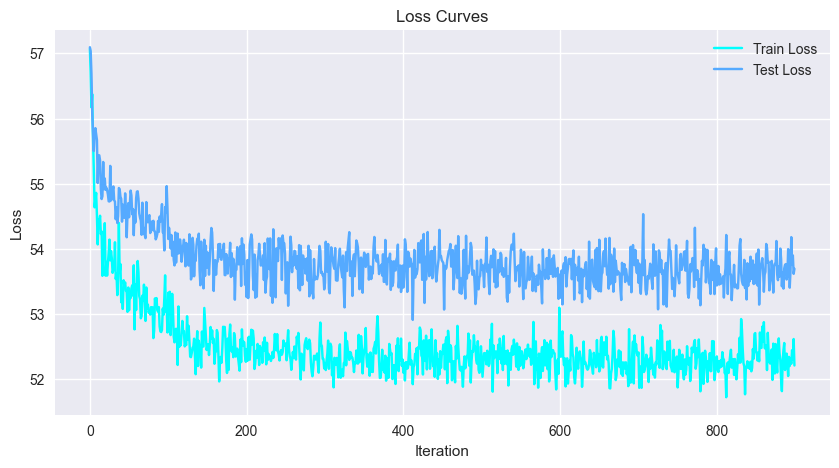

In [18]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist, color=colourmap[0])
plt.plot(test_loss_hist, color=colourmap[1])
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [19]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(
    kmnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    if data.view(data.size(0), -1).shape[0] != batch_size:
      continue

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 5832/10000
Test Set Accuracy: 58.32%


In [20]:
end = time.time()

In [21]:
print("Time taken: ", time.strftime("%H:%M:%S", time.gmtime(end-start)))

Time taken:  00:19:54


In [22]:
end-start

1194.6555151939392

## Metrics

In [23]:
total = 0
correct = 0

# Collect all predictions and true labels
all_preds = []
all_targets = []

# drop_last switched to False to keep all samples
test_loader = DataLoader(
    kmnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        if data.view(data.size(0), -1).shape[0] != batch_size:
            continue

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Collect predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

In [24]:
# Convert lists to numpy arrays for metric calculations
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')

In [25]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Total correctly classified test set images: 5832/10000
Test Set Accuracy: 58.32%
Precision: 0.6273
Recall: 0.5832
F1-Score: 0.5829


## Detailed Metrics

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[619   9   6  11  84  59   0  90  71  51]
 [  2 618  77   7 100   1  71   5  38  81]
 [  5  50 578  62  81   8  77  12  73  54]
 [  2  50  27 718  39  16  10  13  60  65]
 [ 43  56  52  13 674   4  20  17  42  79]
 [  4  90 378  32  69 249  65  14  81  18]
 [  5  22 124  11 140   1 652  13  17  15]
 [  8  27  36   7 293   1  23 441 118  46]
 [ 15  41  51  34  31  10  59   8 730  21]
 [  7  47 114   6 191   2   8  27  45 553]]


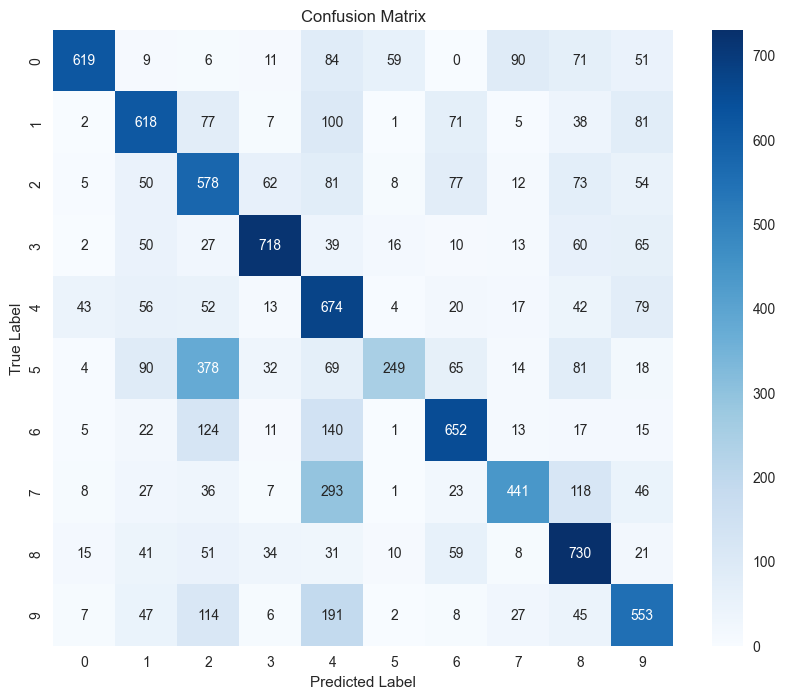

In [27]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Class-wise Performance
class_precision = precision_score(all_targets, all_preds, average=None)
class_recall = recall_score(all_targets, all_preds, average=None)
class_f1 = f1_score(all_targets, all_preds, average=None)

for i in range(len(class_precision)):
    print(f"Class {i}: Precision = {class_precision[i]:.4f}, Recall = {class_recall[i]:.4f}, F1-Score = {class_f1[i]:.4f}")

Class 0: Precision = 0.8718, Recall = 0.6190, F1-Score = 0.7240
Class 1: Precision = 0.6119, Recall = 0.6180, F1-Score = 0.6149
Class 2: Precision = 0.4006, Recall = 0.5780, F1-Score = 0.4732
Class 3: Precision = 0.7969, Recall = 0.7180, F1-Score = 0.7554
Class 4: Precision = 0.3960, Recall = 0.6740, F1-Score = 0.4989
Class 5: Precision = 0.7094, Recall = 0.2490, F1-Score = 0.3686
Class 6: Precision = 0.6619, Recall = 0.6520, F1-Score = 0.6569
Class 7: Precision = 0.6891, Recall = 0.4410, F1-Score = 0.5378
Class 8: Precision = 0.5725, Recall = 0.7300, F1-Score = 0.6418
Class 9: Precision = 0.5626, Recall = 0.5530, F1-Score = 0.5577


In [29]:
# ROC Curve and AUC
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()

# One-hot encode the true labels and predictions for ROC curve calculation
all_targets_one_hot = np.eye(n_classes)[all_targets]
all_preds_one_hot = np.eye(n_classes)[all_preds]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_targets_one_hot[:, i], all_preds_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

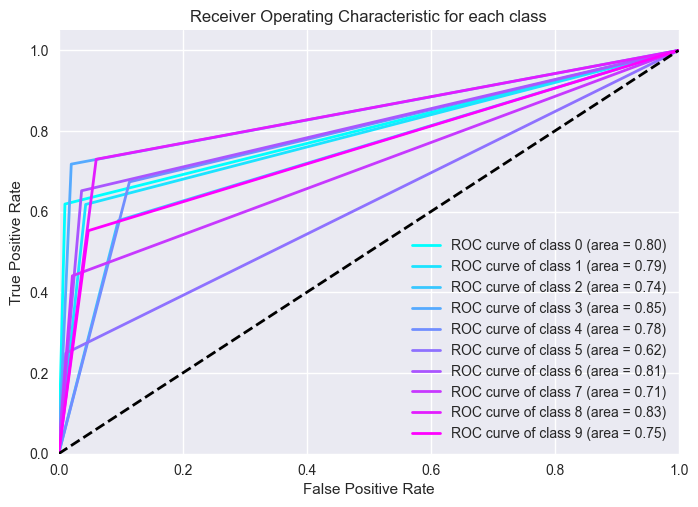

In [30]:
# Plot ROC curve
colors = pl.cm.cool(np.linspace(0, 1, n_classes))
plt.figure()
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

In [31]:
mean_roc_auc = np.mean(list(roc_auc.values()))
mean_roc_auc

0.7684444444444445

In [32]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Total correctly classified test set images: 5832/10000
Test Set Accuracy: 58.32%
Precision: 0.6273
Recall: 0.5832
F1-Score: 0.5829
